In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [40]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text
from dateutil.relativedelta import relativedelta

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()


In [7]:
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [11]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(text("date DESC")).first()

('2017-08-23',)

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = session.query(measurement.date).order_by(text("date DESC")).first()

# Calculate the date one year from the last date in data set.
latest_date = pd.to_datetime(most_recent[0]).date()
one_year_ago = latest_date - relativedelta(years=1)
one_year_ago = str(one_year_ago)
one_year_ago 

'2016-08-23'

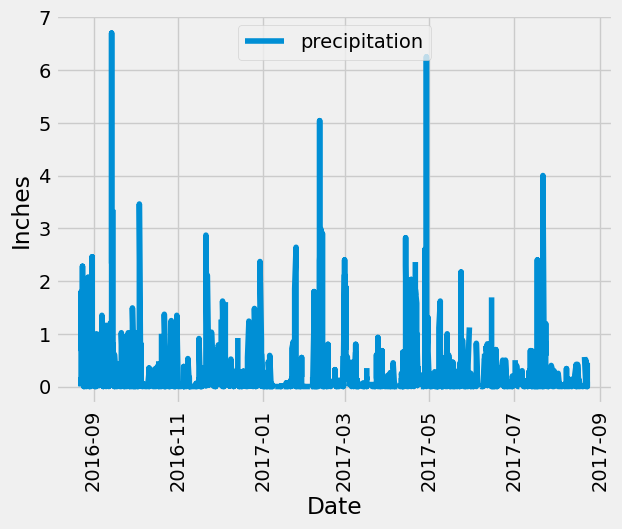

In [54]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = (session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).order_by(measurement.date).all())

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_data)

# Sort the dataframe by date
prcp_df["date"] = pd.to_datetime(prcp_df["date"]).dt.date
prcp_df = prcp_df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(x="date", y="prcp")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
ax.legend(["precipitation"], loc='upper center')
plt.show()

In [60]:
# Use Pandas to calculate the summary statistics for the precipitation data
pd.DataFrame(prcp_df["prcp"].describe()).rename(columns={"prcp": "precipitation"})


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [ ]:
# Close Session
session.close()